In [1]:
import numpy as np
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sbn

#print(os.listdir("/home/sam2220/Desktop/ML_projects/NY_taxi_fare_prediction/kaggle_challenge_dataset"))

In [2]:
#read train and test dataset 
TRAIN_PATH = "/home/sam2220/Desktop/ML_projects/NY_taxi_fare_prediction/kaggle_challenge_dataset/train.csv"
TEST_PATH = "/home/sam2220/Desktop/ML_projects/NY_taxi_fare_prediction/kaggle_challenge_dataset/test.csv"
'''
with open(TRAIN_PATH) as file:
    len_train = len(file.readlines())

print(len_train)
'''

'\nwith open(TRAIN_PATH) as file:\n    len_train = len(file.readlines())\n\nprint(len_train)\n'

In [3]:
#train_temp = pd.read_csv(TRAIN_PATH, nrows=5)
#print("training dataset head:")
#print(train_temp)
#test_temp = pd.read_csv(TEST_PATH, nrows=5)
#print("test dataset head:")
#print(test_temp)

In [8]:
#chunksize = 1000

train_types = {'fare_amount': 'float32',
              'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

test_types =  {'pickup_datetime': 'str', 
              'pickup_longitude': 'float32',
              'pickup_latitude': 'float32',
              'dropoff_longitude': 'float32',
              'dropoff_latitude': 'float32',
              'passenger_count': 'uint8'}

train_cols = list(train_types.keys())
test_cols = list(test_types.keys())

def clean_df(PATH, cols, datatypes, chunksize):
    if PATH == TEST_PATH:
        df_list = []
        for chunk in pd.read_csv(PATH, usecols = cols, dtype=datatypes, chunksize=chunksize):
            chunk['pickup_datetime'] = chunk['pickup_datetime'].str.slice(0, 16)
            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'], utc=True, 
                                                      format='%Y-%m-%d %H:%M')

            df_list.append(chunk)
            #print(len(df_list))
        return pd.concat(df_list)
    
    elif(PATH == TRAIN_PATH):
        X_df_list = []
        y_df_list = []
        #df_list = []
        for chunk in pd.read_csv(PATH, usecols = cols, dtype=datatypes, chunksize=chunksize, nrows=1000000):  
            #converting pickup datetime to proper format
            chunk['pickup_datetime'] = chunk['pickup_datetime'].str.slice(0, 16)
            chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'], utc=True, 
                                                      format='%Y-%m-%d %H:%M')
            #outlier removal
            #remove rows with passenger count 0 and more than 6
            chunk = chunk[(chunk['passenger_count'] > 0) & (chunk['passenger_count'] < 7) ]
            
            #remove rows with fare amount less than $2 and greater than $400 
            chunk = chunk[(chunk['fare_amount'] > 2.0) & (chunk['fare_amount'] < 400.0)]            
            
            #add datetime features to the data 
            #pickup_datetime -> hour, month, year, isWeekday, day
            add_datetime_features(chunk)
            
            #removing data with missing points -> (does not affect the number of sample points)
            #chunk = chunk.dropna(how = 'any', axis = 'rows')
            
            #add distance travelled by the cab to dataframe
            chunk['haversine_distnace'] = add_distance(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)

            #add direction of the distance
            chunk['direction'] = calculate_direction(chunk.pickup_latitude, chunk.pickup_longitude,
                        chunk.dropoff_latitude, chunk.dropoff_longitude)            
            
            chunk = chunk[(chunk['haversine_distnace'] > 0.1) & (chunk['haversine_distnace'] < 100)] 
            
            #appending chunks to the dataframe list
            #df_list.append(chunk)
            y_df_list.append(chunk['fare_amount'])
            chunk.drop(labels = 'fare_amount', axis=1, inplace=True)
            X_df_list.append(chunk)
            
        #df = pd.concat(df_list)
        X_df = pd.concat(X_df_list)
        y_df = pd.concat(y_df_list)
        return  X_df, y_df

def add_datetime_features(data_chunk):
    data_chunk['hour'] = data_chunk.pickup_datetime.dt.hour
    data_chunk['day'] = data_chunk.pickup_datetime.dt.day
    data_chunk['month'] = data_chunk.pickup_datetime.dt.month
    data_chunk['weekday'] = data_chunk.pickup_datetime.dt.weekday
    data_chunk['year'] = data_chunk.pickup_datetime.dt.year
    
    return data_chunk
    
def add_distance(lat1, lon1, lat2, lon2):
    p = np.pi/180.0
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) # 2*R*asin...    

def calculate_direction(pickup_lat, pickup_lon, dropoff_lat, dropoff_lon):
    """
    Return distance along great radius between pickup and dropoff coordinates.
    """
    #Define earth radius (km)
    R_earth = 6371
    #Convert degrees to radians
    pickup_lat, pickup_lon, dropoff_lat, dropoff_lon = map(np.radians,
                                                             [pickup_lat, pickup_lon, 
                                                              dropoff_lat, dropoff_lon])
    #Compute distances along lat, lon dimensions
    dlat = dropoff_lat - pickup_lat
    dlon = pickup_lon - dropoff_lon
    
    #Compute bearing distance
    a = np.arctan2(np.sin(dlon * np.cos(dropoff_lat)),np.cos(pickup_lat) * np.sin(dropoff_lat) - np.sin(pickup_lat) * np.cos(dropoff_lat) * np.cos(dlon))
    return a

#insample dataset
train_target, train_label = clean_df(TRAIN_PATH, train_cols, train_types, chunksize = 50000)
#n_train = len(train_label)
print(train_target.shape)

#out of samples dataset
#test_dataset = clean_df(TEST_PATH, test_cols, test_types, chunksize = 2000)
#n_test = len(test_dataset)
#print(n_test)

(958546, 13)


In [9]:
train_target.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,weekday,year,haversine_distnace,direction
count,958546.000000,958546.000000,958546.000000,958546.000000,958546.000000,958546.000000,958546.000000,958546.000000,958546.000000,958546.000000,958546.000000,958546.000000
mean,-73.143059,40.318642,-73.140427,40.318661,1.692181,13.516277,15.694221,6.269563,3.039349,2011.747400,2.120711,0.308140
std,2.746906,2.632319,2.748294,2.607895,1.306795,6.510949,8.682668,3.437157,1.949542,1.866744,2.543168,1.832241
min,-78.650909,-74.016586,-78.659447,-74.035194,1.000000,0.000000,1.000000,1.000000,0.000000,2009.000000,0.100071,-3.141503
25%,-73.992279,40.736588,-73.991570,40.735588,1.000000,9.000000,8.000000,3.000000,1.000000,2010.000000,0.805444,-0.892707
50%,-73.982109,40.753410,-73.980621,40.753880,1.000000,14.000000,16.000000,6.000000,3.000000,2012.000000,1.363956,-0.125228
75%,-73.968491,40.767574,-73.965515,40.768421,2.000000,19.000000,23.000000,9.000000,5.000000,2013.000000,2.470330,2.261664
max,40.850357,401.083344,40.851028,51.346519,6.000000,23.000000,31.000000,12.000000,6.000000,2015.000000,92.051299,3.141593


In [10]:
#drop location features as the distance has already been calculated and added to the dataset
features_to_drop = ['pickup_longitude',	'pickup_latitude', 'dropoff_longitude',	'dropoff_latitude']
train_target.drop(labels = features_to_drop, axis=1, inplace=True)
print(train_target.shape)

(958546, 9)


Text(0.5, 1.0, 'Histogram ride distances in miles')

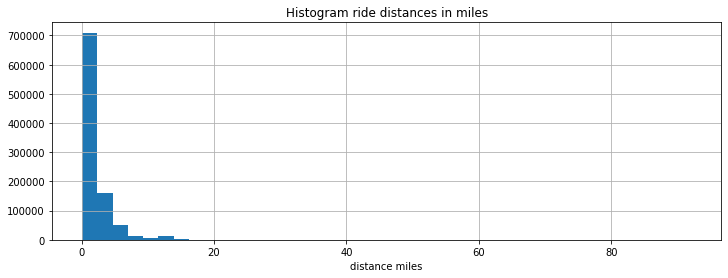

In [11]:
#histogram of haversine distance 
train_target[train_target.haversine_distnace<100].haversine_distnace.hist(bins=40, figsize=(12,4))
plt.xlabel('distance miles')
plt.title('Histogram ride distances in miles')

(958546, 10)


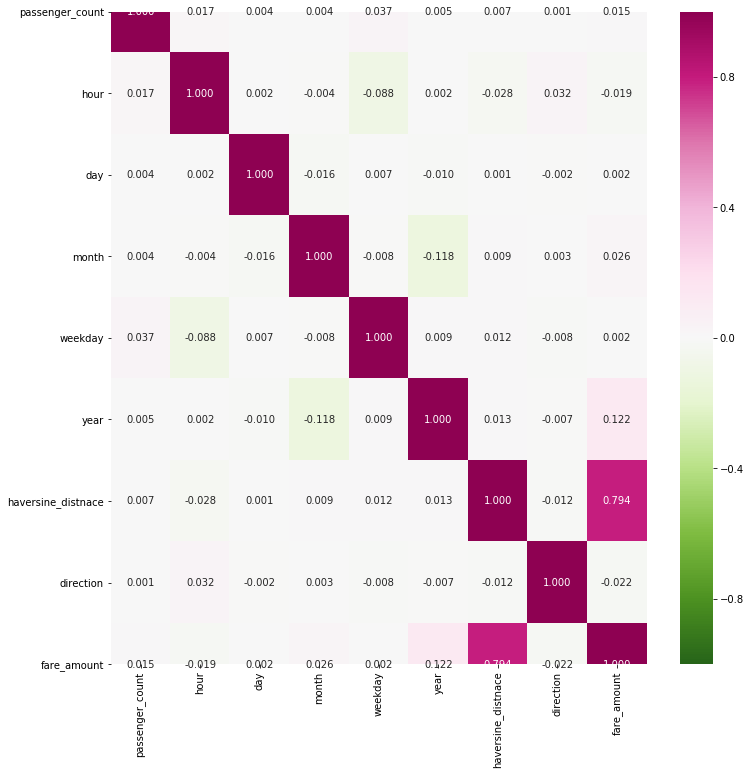

In [12]:
train_df = pd.concat([train_target, train_label], axis = 1)
print(train_df.shape)

corrs = train_df.corr()
plt.figure(figsize = (12, 12))
sbn.heatmap(corrs, annot = True, vmin = -1, vmax = 1, fmt = '.3f', cmap=plt.cm.PiYG_r);
